# Elastic wave equation implementation on a staggered grid

This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

In [1]:
from devito import *
from examples.seismic.source import WaveletSource, RickerSource, GaborSource, TimeAxis
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

%matplotlib qt

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
#Fairly sure grid is actually 2km x 2km with spacing 10m
shape = (201, 201)
#Define x and z as spatial dimentions for Sympy
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
#Dimension called x, with constant spacing of 10 (called h_x) 
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))
#Cartesian grid with dimensions of x and z. 201 x 201 gridpoints and measuring 2km x 2km

In [3]:
#Class for gaussian pulse
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t): #Evaluates the wave at a given value of t
        a = 0.004
        return -2.*a*(t - 1/f0) * np.exp(-a * (t - 1/f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100 <- Paper 2
t0, tn = 0., 600.
dt = (10. / np.sqrt(2.)) / 6. #Would expect 6 to be 6000 (km vs m)
time_range = TimeAxis(start=t0, stop=tn, step=dt) #Set up time axis object for ricker source

src = RickerSource(name='src', grid=grid, f0=0.01, time_range=time_range) #Ricker wavelet source
src.coordinates.data[:] = [1000., 1000.] #2 element array containing x and z positions of source
src.show() #Show the source function

AttributeError: 'list' object has no attribute 'ndim'

In [19]:
# Now we create the velocity and pressure fields
so = 2 #Spatial derivatives are second order accurate
#Grids are staggered to prevent pressure decoupling. Note that staggering is done in corresponding directions
vx= TimeFunction(name='vx', grid=grid, staggered=x, space_order=so) #Velocity field x
vz = TimeFunction(name='vz', grid=grid, staggered=z, space_order=so) #Velocity field z
# staggered=x entails discretization on x edges
txx = TimeFunction(name='txx', grid=grid, staggered=NODE, space_order=so) #Second derivitive wrt x of pressure?
tzz = TimeFunction(name='tzz', grid=grid, staggered=NODE, space_order=so) #Second derivitive wrt z of pressure?
txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so) #Mixed derivative of pressure?


In [20]:
# Now let's try and create the staggered updates
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
V_s = 1.0
density = 3. #Units seem inconsistent

# The source injection term
src_xx = src.inject(field=txx.forward, expr=src) #Inject the ricker source into the x and z fields
src_zz = src.inject(field=tzz.forward, expr=src)

#c1 = 9.0/8.0;
#c2 = -1.0/24.0;

# Thorbecke's parameter notation
cp2 = V_p*V_p #Why not just **2?
cs2 = V_s*V_s
ro = 1/density #Not sure why 1/density

mu = cs2*ro
l = (cp2*ro - 2*mu)

# fdelmodc reference implementation
u_vx = Eq(vx.forward, vx - dt*ro*(txx.dx + txz.dz)) #PDEs for updating all fields

u_vz = Eq(vz.forward, vz - ro*dt*(txz.dx + tzz.dz))

u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz)
u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx)

u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx))

In [21]:
op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz) #Operator can iterate multiple PDEs at once
#Source is injected in xx and zz directions

In [22]:
# Reset the fields
vx.data[:] = 0. #Velocity components
vz.data[:] = 0.
txx.data[:] = 0. #Symmetric stress tensors
tzz.data[:] = 0.
txz.data[:] = 0.

op()

Operator `Kernel` run in 0.27 s


In [24]:
# Let's see what we got....
plot_image(vx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")


In [ ]:
plot_image(vz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")


In [25]:
plot_image(txx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")


In [ ]:
plot_image(tzz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")


In [26]:
plot_image(txz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")

vx(t, x, z) x (0, 1, 0)
vx(t, x, z) {t: left, x: right, z: left} <function staggered_diff at 0x7fac72a1a620>
vz(t, x, z) z (0, 0, 1)
vz(t, x, z) {t: left, x: left, z: right} <function staggered_diff at 0x7fac72a1a620>
txx(t, x, z) node (0, 0, 0)
txx(t, x, z) {t: left, x: left, z: left} <function staggered_diff at 0x7fac72a1a620>
tzz(t, x, z) node (0, 0, 0)
tzz(t, x, z) {t: left, x: left, z: left} <function staggered_diff at 0x7fac72a1a620>
txz(t, x, z) (x, z) (0, 1, 1)
txz(t, x, z) {t: left, x: right, z: right} <function staggered_diff at 0x7fac72a1a620>


GNUCompiler: compiled `/tmp/devito-jitcache-uid944902/c9839d148f7ed3b1bc27d4bb3219351ae6a60553.c` [0.37 s]
section0<<510,201,201>,<510,201,201>> with OI=8.07 computed in 0.207 s [33.59 GFlops/s, 0.50 GPts/s]
section1<<510,1>,<510,1>,<510,1>,<510,1>,<510,1>,<510,1>,<510,1>> with OI=9.67 computed in 0.000 s [4.73 GFlops/s, 0.16 GPts/s]


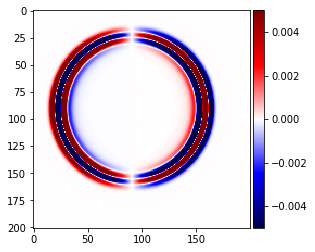

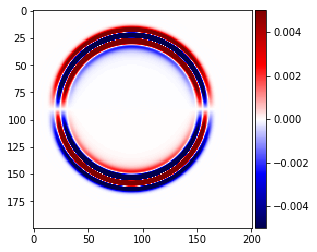

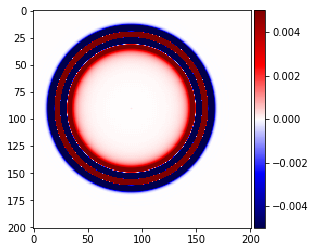

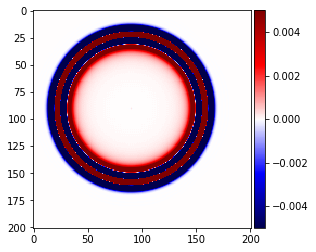

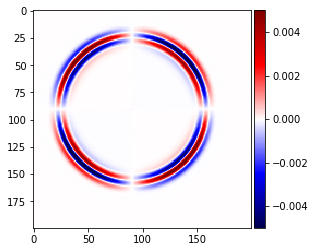

In [9]:
# Now that looks pretty! But let's do it again with a higher order...
so = 12
vx= TimeFunction(name='vx', grid=grid, staggered=x, space_order=so)
vz = TimeFunction(name='vz', grid=grid, staggered=z, space_order=so)
txx = TimeFunction(name='txx', grid=grid, staggered=NODE, space_order=so)
tzz = TimeFunction(name='tzz', grid=grid, staggered=NODE, space_order=so)
txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so)

# fdelmodc reference implementation
u_vx = Eq(vx.forward, vx - dt*ro*(txx.dx + txz.dz))

u_vz = Eq(vz.forward, vz - ro*dt*(txz.dx + tzz.dz))

u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * vx.forward.dx -  l*dt * vz.forward.dz)
u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * vz.forward.dz -  l*dt * vx.forward.dx)

u_txz = Eq(txz.forward, txz - mu*dt * (vx.forward.dz + vz.forward.dx))

op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz)

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
txx.data[:] = 0.
tzz.data[:] = 0.
txz.data[:] = 0.

op()

plot_image(vx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(vz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(txx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(tzz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(txz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")